# 03-Visual-search-with-k-NN.ipynb

The idea here is to implement a little search engine based on the high-level image representation and k-nearest neighbors

3. Pick an image which was correctly classified in the test set and plot its 10 nearest neighbors from the training set. An example is depicted below
4. Pick an image which was misclassified in the test set and plot its 10 neighbors from the training set

#### 1. Fit and tune a k-NN classifier. Visualize the train and validation curves


In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from IPython.display import display
import PIL.Image as Image
from sklearn.neighbors import NearestNeighbors


/Applications/anaconda3/envs/adsml/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2024-04-24 16:37:51.244198: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Loading files
train_features = np.load('train_features.npz')['features']
train_labels = np.load('labelled_train_features.npz')['labels']
valid_features = np.load('valid_features.npz')['features']
valid_labels = np.load('labelled_valid_features.npz')['labels']
test_features = np.load('test_features.npz')['features']
test_labels = np.load('labelled_test_features.npz')['labels']

In [3]:
#creating x and y for train and valid

#y
labels_df_train = pd.DataFrame(train_labels) 
labels_df_valid = pd.DataFrame(valid_labels) 
labels_df_test = pd.DataFrame(test_labels) 

y_tr = labels_df_train.values
y_val = labels_df_valid.values
y_te = labels_df_test.values

#x
features_df_train = pd.DataFrame(train_features) 
features_df_valid = pd.DataFrame(valid_features) 
features_df_test = pd.DataFrame(test_features)
X_tr = features_df_train.values
X_val = features_df_valid.values
X_te = features_df_test.values

print('shape of y_tr: ',y_tr.shape, ' and of X_tr: ',X_tr.shape)
print('shape of y_val: ',y_val.shape, ' and of X_val: ',X_val.shape)
print('shape of y_te: ',y_te.shape, ' and of X_te: ',X_te.shape)

shape of y_tr:  (280, 1)  and of X_tr:  (280, 1280)
shape of y_val:  (139, 1)  and of X_val:  (139, 1280)
shape of y_te:  (50, 1)  and of X_te:  (50, 1280)


As KNeighborsClassifier may encounter problems with 2 dimentional labels ex (280,1), I will flatten them to 1 dimention

In [4]:
# flattening y
y_tr = y_tr.flatten()
y_val = y_val.flatten()
y_te = y_te.flatten()
print('shape of y_tr: ',y_tr.shape, ', of y_val :',y_val.shape, ' and of y_te :',y_te.shape)

shape of y_tr:  (280,) , of y_val : (139,)  and of y_te : (50,)


#### 1.1 Running k-NN with for k = 5 (warm-up)

In [5]:
# Create a k-NN pipeline
knn_pipe = Pipeline(
    [("scaler", StandardScaler()), 
     ("knn", KNeighborsClassifier(n_neighbors=5))]
)

# Fit estimator
knn_pipe.fit(X_tr, y_tr)

# Evaluate on validation set
accuracy = knn_pipe.score(X_val, y_val)
print("Accuracy: {:.3f}".format(accuracy))

Accuracy: 0.259


with such low accurancy, n=5 will unlikely be the optimal parameter. Just by curiosity, what is the baseline?

In [6]:
# Baseline accurancy
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(None, y_tr)
accuracy = dummy.score(None, y_te)
print("Accuracy: {:.2f}".format(accuracy))

Accuracy: 0.24


The above model didnt do really better than the baseline

#### 1.2 Grid search for tuning k

In [7]:
# Generate a set of k values (1 to 100)
k_values = np.r_[1, np.arange(5, 101, step=5)]

In [8]:
gs_results = []

# Grid search
for k in k_values:
    knn_pipe.set_params(knn__n_neighbors=k)
    knn_pipe.fit(X_tr, y_tr)
    gs_results.append(
        {
            "k": k,
            "train_accuracy": knn_pipe.score(X_tr, y_tr),
            "valid_accuracy": knn_pipe.score(X_val, y_val),
        }
    )

# Convert results to DataFrame
gs_results = pd.DataFrame(gs_results)
gs_results_sorted = gs_results.sort_values(by="valid_accuracy", ascending=False).copy()
gs_results_sorted.head()

,k,train_accuracy,valid_accuracy
15,75,0.282143,0.395683
17,85,0.257143,0.388489
16,80,0.275000,0.388489
18,90,0.257143,0.381295
13,65,0.278571,0.381295


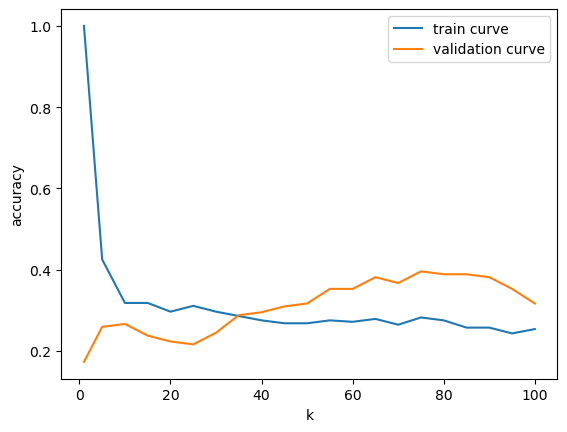

In [9]:
# plot training and validation curves
%matplotlib inline
import matplotlib.pyplot as plt

# Plot the validation curves
plt.plot(gs_results["k"], gs_results["train_accuracy"], label="train curve")
plt.plot(gs_results["k"], gs_results["valid_accuracy"], label="validation curve")
plt.ylabel("accuracy")
plt.xlabel("k")
plt.legend()
plt.show()

Observation : <br>
    Intrestingly, beyond a certain values of k, the accuracy on the validation set is higher than on the train set. In fact, with larger k, the complexity of the model is reduced, its decision boundries smoother and it generalises better.

### 1.3 rerunning the model with the best k and evaluating it on the test set

In [10]:
# runing the model on the test set with the best k
best_k = gs_results_sorted.iloc[0,0]
best_k

75

In [11]:
# Create a k-NN pipeline
knn_pipe2 = Pipeline(
    [("scaler", StandardScaler()), 
     ("knn", KNeighborsClassifier(n_neighbors=best_k))]
)

# Fit estimator
knn_pipe2.fit(X_tr, y_tr)

# Evaluate on validation set
accuracy = knn_pipe2.score(X_te, y_te)
print("Test Accuracy: {:.3f}".format(accuracy))

Test Accuracy: 0.440


Observation : <br>
What probably affects these results is be the **curse of dimentionality**. The larger the feature space (1280), the less it is populated with data, which is a problem for a distance-based model. 

### 2. Provide a classification report and visualize the confusion matrix of the test dataset

Note: <br>
The best results were obtained with k = 5, so we already have a fitted model for this parameter

In [12]:
# predicting
y_pred= knn_pipe2.predict(X_te)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 2, 1, 0,
       1, 1, 0, 1, 1, 0], dtype=int32)

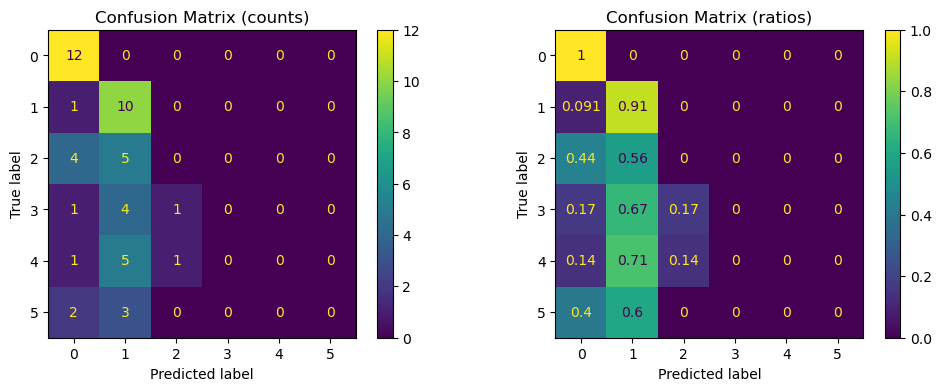

In [13]:
# Consufion matrix

from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrices(y_true, y_pred):

    # Create two subplots
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Plots the standard confusion matrix
    ax1.set_title("Confusion Matrix (counts)")
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, ax=ax1)

    # Plots the normalized confusion matrix
    ax2.set_title("Confusion Matrix (ratios)")
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, normalize="true", ax=ax2)

    plt.show()


# Plot confusion matrices
plot_confusion_matrices(y_te, y_pred)

Observation: <br>
The algorith has a sound capability of predicting bikes and half of the time predicts cars correctly too. All other categories (except for bikes) are aften mistaken for cars.

In [14]:
report = classification_report(y_true=y_te, y_pred=y_pred, zero_division=0.0)
print(report)

              precision    recall  f1-score   support

           0       0.57      1.00      0.73        12
           1       0.37      0.91      0.53        11
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00         7
           5       0.00      0.00      0.00         5

    accuracy                           0.44        50
   macro avg       0.16      0.32      0.21        50
weighted avg       0.22      0.44      0.29        50



### Interpretation

**Precision:** out of all instances predicted as a given class, how many were correct? Ex 57% of vehicles predicted as bike, 57% were bikes indeed.

**Recall:** out of all actual instances belonging to a give class, how many were correctly identified.

 & F1 is a linear combination of the two scores
 
**Accuracy**: 44% of instances were correctly classified across all classes 

#### 3. Pick an image which was correctly classified in the test set and plot its 10 nearest neighbors from the training set. An example is depicted below.Take a look at the kneighbors() method from Scikit-learn k-NN estimators.

##### 3.1 selecting correctly classified picture from the set

In [15]:
#what are the indices of pictures correctly classified?
correctly_classified_idx = np.where(y_pred == y_te)
correctly_classified_idx

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22]),)

In [16]:
#pick one image (ex first one)
correctly_classified_picture_idx = correctly_classified_idx[0][0]
print('index of correctly classified picture: ',correctly_classified_picture_idx)
correct_picture_image_path = f"swissroads/train/bike/bike-{correctly_classified_picture_idx+1:04d}.png"
print('path of correctly classified picture: ',correct_picture_image_path)

index of correctly classified picture:  0
path of correctly classified picture:  swissroads/train/bike/bike-0001.png


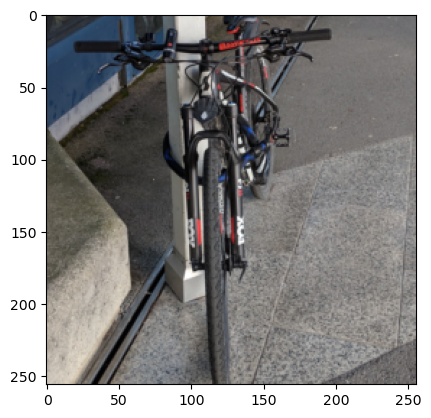

In [17]:
#plot the image
img2 = Image.open(correct_picture_image_path)
img2 = np.array(img2)
%matplotlib inline
plt.imshow(img2)
plt.show()

##### 3.2 extracting MobileNet v2 high level features 
In order to compute the ditances between this pictures features and those of other ones from the training set, I have to make sure these features are expressed in the same way.
For this, I have to apply the same feature extractor from MobileNet v2. I have already done it in the task 1 (01 Data exploration and feature extraction), so will now rerun the same code.

In [18]:
img2 = Image.open(correct_picture_image_path)
img_resized2 = img2.resize([224, 224], resample=Image.BILINEAR)  # Expected size
img_batch2 = np.array(img_resized2, dtype=np.float32)[np.newaxis, :, :, :] / 255
print("Batch size:", img_batch2.shape)

# Create the image feature extractor
model_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5"
feature_extractor = hub.load(model_url)

# Extract features
features2 = feature_extractor(img_batch2)
features2.shape

# set in a format allowing to run kneighbors()
features2_np = np.array(features2)
features2_reshaped = features2_np.reshape(1, -1)

Batch size: (1, 224, 224, 3)


##### 3.3 Extracting the feature matrix relative to bikes only

In [19]:
X_tr.shape

(280, 1280)

In [20]:
X_tr_bike = X_tr[0:66,:]
X_tr_bike.shape

(66, 1280)

Observation: <br>
The first 66 rows in the feature matrix correspond to bike images (as its the first folder in the train and it contains 66 images)    

##### 3.4 Using kneighbors() to find the nearest neighbors of the test image. 

In [21]:
nbrs = NearestNeighbors(n_neighbors=10, algorithm='auto').fit(X_tr_bike)
distances, indices = nbrs.kneighbors(features2_reshaped)

#What are tese closest neigbors of our test image?
for i, (idx, dist) in enumerate(zip(indices[0], distances[0])):
    print(f"Closest neighbor {i+1}: Picture index {idx}, Distance {round(dist, 2)}")

Closest neighbor 1: Picture index 16, Distance 18.91
Closest neighbor 2: Picture index 59, Distance 19.43
Closest neighbor 3: Picture index 63, Distance 19.46
Closest neighbor 4: Picture index 13, Distance 19.67
Closest neighbor 5: Picture index 25, Distance 20.74
Closest neighbor 6: Picture index 18, Distance 20.74
Closest neighbor 7: Picture index 0, Distance 21.09
Closest neighbor 8: Picture index 52, Distance 21.26
Closest neighbor 9: Picture index 60, Distance 21.26
Closest neighbor 10: Picture index 2, Distance 21.28


##### 3.5 Finding and plotting these pictures 

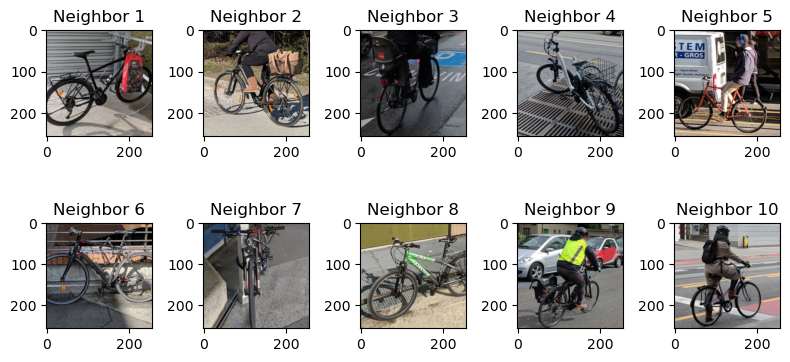

In [22]:
plt.figure(figsize=(8, 4))
for i, idx in enumerate(indices[0]):
    image_path = f"swissroads/train/bike/bike-{idx+1:04d}.png"
    neighbor_img = Image.open(image_path)
    plt.subplot(2, 5, i + 1)
    plt.imshow(neighbor_img)
    plt.title(f"Neighbor {i+1}")

plt.tight_layout()
plt.show()

## 4. Pick an image which was misclassified in the test set and plot its 10 neighbors from the training set

#### 4.1 Selecting a misclassified picture

In [23]:
#what are the indices of pictures correctly classified?
misclassified_idx = np.where(y_pred != y_te)
misclassified_idx

(array([12, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
        39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),)

In [24]:
#pick one image (first from the list)
misclassified_picture_idx = misclassified_idx[0][0]

print('index of misclassified picture: ',misclassified_picture_idx)
misclassified_picture_image_path = f"swissroads/train/bike/bike-{misclassified_picture_idx+1:04d}.png"
print('path of misclassified picture: ',misclassified_picture_image_path)

index of misclassified picture:  12
path of misclassified picture:  swissroads/train/bike/bike-0013.png


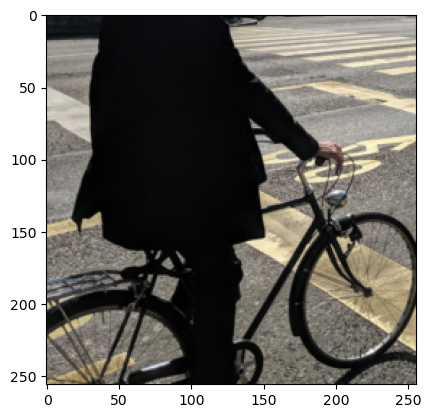

In [25]:
#plot the image
pillow_img3 = Image.open(misclassified_picture_image_path)
img3 = np.array(pillow_img3)
%matplotlib inline
plt.imshow(img3)
plt.show()

#### extracting features

In [26]:
img3 = Image.open(misclassified_picture_image_path)
img_resized3 = img3.resize([224, 224], resample=Image.BILINEAR)  # Expected size
img_batch3 = np.array(img_resized3, dtype=np.float32)[np.newaxis, :, :, :] / 255
print("Batch size:", img_batch3.shape)

# Create the image feature extractor
#model_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5"
feature_extractor = hub.load(model_url)

# Extract features
features3 = feature_extractor(img_batch3)
features3.shape

# set in a format allowing to run kneighbors()
features3_np = np.array(features3)
features3_reshaped = features3_np.reshape(1, -1)

Batch size: (1, 224, 224, 3)


##### 4.2 plotting its closest neighbors trom the trainset

In [27]:
nbrs = NearestNeighbors(n_neighbors=10, algorithm='auto').fit(X_tr_bike)
distances, indices = nbrs.kneighbors(features3_reshaped)

#What are tese closest neigbors of our test image?
for i, (idx, dist) in enumerate(zip(indices[0], distances[0])):
    print(f"Closest neighbor {i+1}: Picture index {idx}, Distance {round(dist, 2)}")

Closest neighbor 1: Picture index 25, Distance 20.52
Closest neighbor 2: Picture index 41, Distance 20.83
Closest neighbor 3: Picture index 13, Distance 20.92
Closest neighbor 4: Picture index 40, Distance 21.05
Closest neighbor 5: Picture index 63, Distance 21.11
Closest neighbor 6: Picture index 0, Distance 21.11
Closest neighbor 7: Picture index 60, Distance 21.21
Closest neighbor 8: Picture index 16, Distance 21.44
Closest neighbor 9: Picture index 18, Distance 21.84
Closest neighbor 10: Picture index 59, Distance 22.31


##### 4.3 plotting the closest neighbors

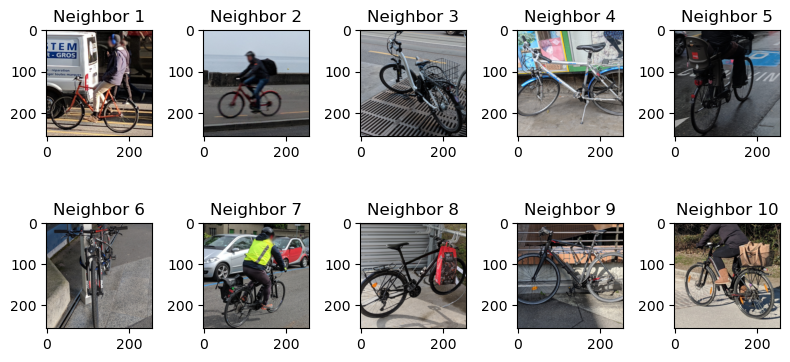

In [28]:
plt.figure(figsize=(8, 4))
for i, idx in enumerate(indices[0]):
    image_path = f"swissroads/train/bike/bike-{idx+1:04d}.png"
    neighbor_img = Image.open(image_path)
    plt.subplot(2, 5, i + 1)
    plt.imshow(neighbor_img)
    plt.title(f"Neighbor {i+1}")

plt.tight_layout()
plt.show()

Observation: <br>
There seem to be more background noice in the misclassified picture and its closest neigbours which may have led to this misclassification.